In [1]:
import anndata as ad

# Load the AnnData object from the file
adata = ad.read('../data/xenium/outs/transcripts_anndata_with_start_end_coords.h5ad')

# Now adata contains the data from the file
print(adata)

/Users/lollijagladiseva/anaconda3/lib/python3.11/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 3204769 × 541
    obs: 'start_x', 'start_y', 'end_x', 'end_y'
    uns: 'bin_size_pixels'
    obsm: 'spatial'


In [2]:
center_x = (adata.obs['start_x'] + adata.obs['end_x']) / 2
center_y = (adata.obs['start_y'] + adata.obs['end_y']) / 2

In [14]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import Voronoi
from shapely.geometry import Polygon, MultiPolygon

coordinates = np.vstack([center_x, center_y]).T

# Create Voronoi tessellation
vor = Voronoi(coordinates)

# Convert Voronoi regions to Shapely polygons
def voronoi_to_polygons(vor):
    polygons = []
    for region in vor.regions:
        if not -1 in region and len(region) > 0:
            polygon = Polygon([vor.vertices[i] for i in region])
            polygons.append(polygon)
    return polygons

vor_polygons = voronoi_to_polygons(vor)

# Convert Voronoi polygons to GeoDataFrame
vor_gdf = gpd.GeoDataFrame(geometry=vor_polygons)


In [15]:
vor_gdf.to_file('../data/xenium/voronoi.geojson', driver='GeoJSON')

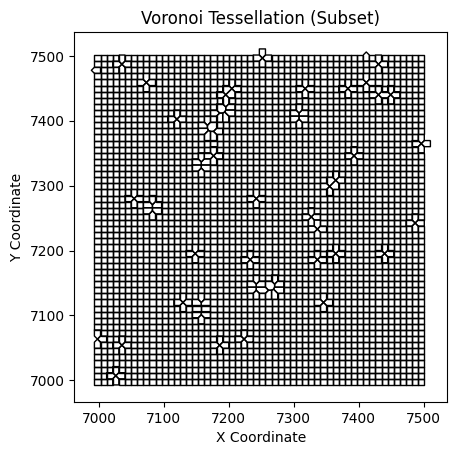

In [38]:
# Define bounding box (xmin, ymin, xmax, ymax)
bbox = (7000, 7000, 7500, 7500)  # Replace with your desired bounding box

# Create a Polygon for the bounding box
bbox_polygon = Polygon([
    (bbox[0], bbox[1]),
    (bbox[0], bbox[3]),
    (bbox[2], bbox[3]),
    (bbox[2], bbox[1]),
    (bbox[0], bbox[1])
])

# Filter GeoDataFrame to only include polygons within the bounding box
vor_gdf_small = vor_gdf[vor_gdf.intersects(bbox_polygon)]

# Plotting
fig, ax = plt.subplots()
vor_gdf_small.plot(ax=ax, edgecolor='black', facecolor='none')

plt.title('Voronoi Tessellation (Subset)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

In [34]:
import imageio

# Load the image
img = imageio.imread('../data/xenium/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.ome.tif')

# Print the image shape
print("Image shape:", img.shape)


/var/folders/fd/jw2fvp1178s0spb_1sy9f51h0000gn/T/ipykernel_39672/475591358.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread('../data/xenium/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.ome.tif')


Image shape: (24241, 30786, 3)


Cropped image shape: (500, 500, 3)


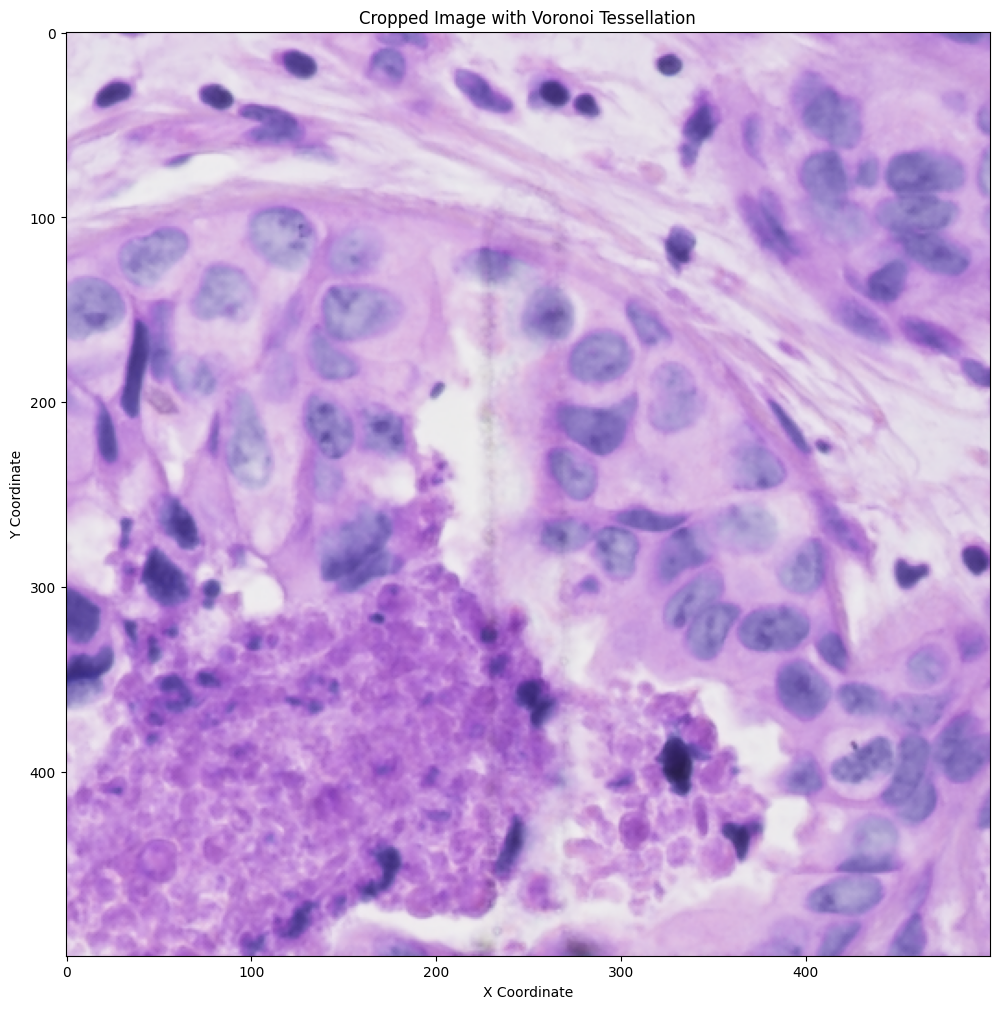

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon as mpl_polygon

# Define bounding box
bbox = (7000, 7000, 7500, 7500)  # xmin, ymin, xmax, ymax

# Ensure bounding box coordinates are within image bounds
bbox = (
    max(0, bbox[0]), 
    max(0, bbox[1]), 
    min(img.shape[1], bbox[2]),  # width
    min(img.shape[0], bbox[3])   # height
)

# Crop the image using adjusted bounding box
# Note: img.shape is (height, width, channels)
cropped_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]]

# Check the shape of the cropped image
print("Cropped image shape:", cropped_img.shape)

# Plot the cropped image and Voronoi tessellation
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the cropped image
ax.imshow(cropped_img, origin='upper')

# Adjust Voronoi tessellation polygons to the bounding box coordinates
for polygon in vor_gdf_small.geometry:
    coords = np.array(polygon.exterior.coords) - np.array([bbox[0], bbox[1]])
    ax.add_patch(mpl_polygon(coords, closed=True, edgecolor='black', facecolor='none'))

# Set plot title and labels
plt.title('Cropped Image with Voronoi Tessellation')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

plt.show()


Cropped image shape: (500, 500, 3)
Polygon coordinates: [[152.94117647 237.64705882]
 [143.52941176 237.64705882]
 [143.52941176 228.23529412]
 [152.94117647 228.23529412]
 [152.94117647 237.64705882]]
Polygon coordinates: [[ 77.64705882 397.64705882]
 [ 77.64705882 407.05882353]
 [ 87.05882353 407.05882353]
 [ 87.05882353 397.64705882]
 [ 77.64705882 397.64705882]]
Polygon coordinates: [[162.35294118 228.23529412]
 [152.94117647 228.23529412]
 [152.94117647 237.64705882]
 [162.35294118 237.64705882]
 [162.35294118 228.23529412]]
Polygon coordinates: [[ 87.05882353 218.82352941]
 [ 77.64705882 218.82352941]
 [ 77.64705882 228.23529412]
 [ 87.05882353 228.23529412]
 [ 87.05882353 218.82352941]]
Polygon coordinates: [[218.82352941 124.70588235]
 [218.82352941 134.11764706]
 [209.41176471 134.11764706]
 [209.41176471 124.70588235]
 [218.82352941 124.70588235]]
Polygon coordinates: [[ 87.05882353 209.41176471]
 [ 87.05882353 200.        ]
 [ 77.64705882 200.        ]
 [ 77.64705882 209.411

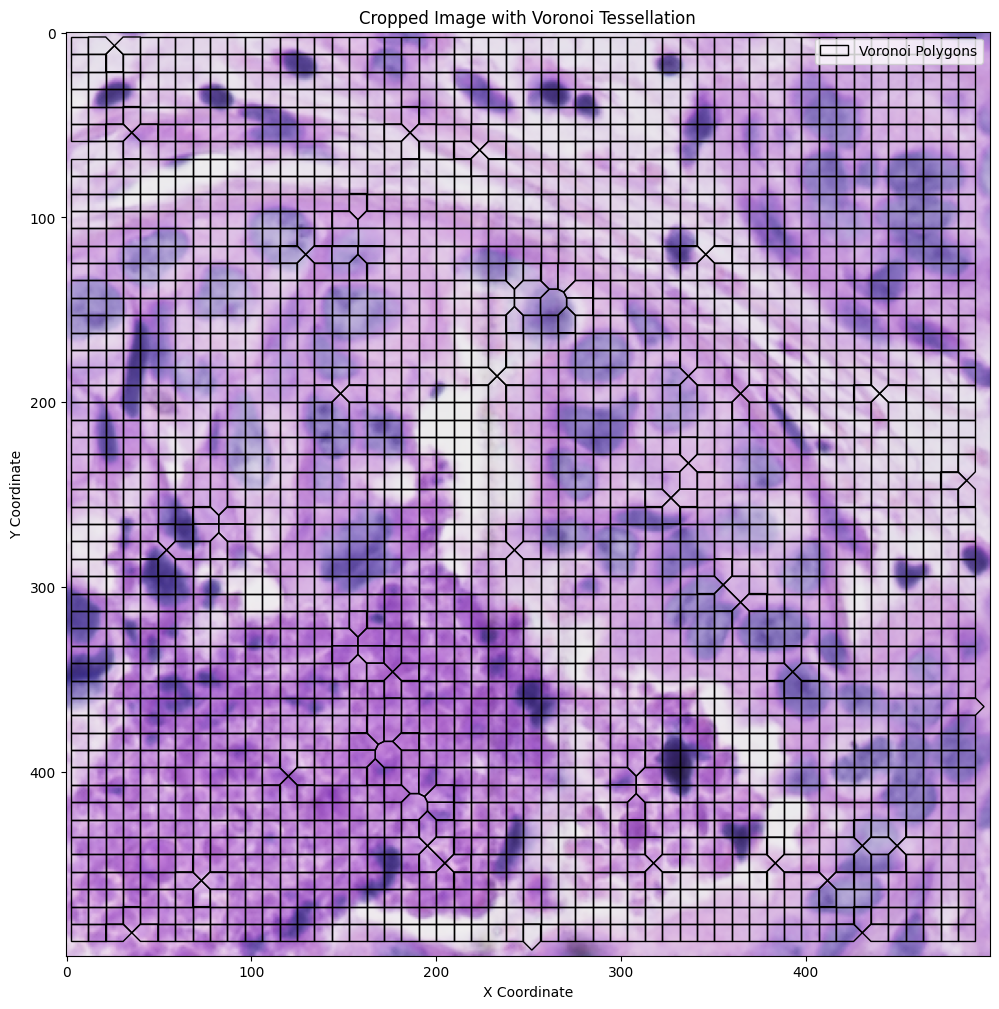

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon as mpl_polygon
from matplotlib.patches import Patch

# Define bounding box
bbox = (7000, 7000, 7500, 7500)  # xmin, ymin, xmax, ymax

# Ensure bounding box coordinates are within image bounds
bbox = (
    max(0, bbox[0]), 
    max(0, bbox[1]), 
    min(img.shape[1], bbox[2]),  # xmax
    min(img.shape[0], bbox[3])   # ymax
)

# Crop the image using adjusted bounding box
cropped_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]]

# Check the shape of the cropped image
print("Cropped image shape:", cropped_img.shape)

# Plot the cropped image and Voronoi tessellation
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the cropped image
ax.imshow(cropped_img, origin='upper')

# Debugging: Plot Voronoi polygons separately to ensure they are generated correctly
for polygon in vor_gdf_small.geometry:
    coords = np.array(polygon.exterior.coords) - np.array([bbox[0], bbox[1]])
    
    # Debug: Print coordinates to check if they are within the cropped image bounds
    print("Polygon coordinates:", coords)
    
    # Ensure coordinates are within the bounds of the image
    if coords.size > 0 and np.all(coords[:, 0] >= 0) and np.all(coords[:, 0] <= cropped_img.shape[1]) and np.all(coords[:, 1] >= 0) and np.all(coords[:, 1] <= cropped_img.shape[0]):
        ax.add_patch(mpl_polygon(coords, closed=True, edgecolor='black', facecolor='none'))
    else:
        print("Polygon out of bounds or empty:", coords)

# Optionally, add a legend
legend_elements = [Patch(edgecolor='black', facecolor='none', label='Voronoi Polygons')]
ax.legend(handles=legend_elements, loc='upper right')

# Set plot title and labels
plt.title('Cropped Image with Voronoi Tessellation')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

plt.show()
